# This script will pair the Udacity driving data between steering angle and center camera image file name based on closest timestamp in Epoch time
Created by: Zhongtao Yang
Date: 11/4/2016

It uses pandas to read two csv files and find the best pairing based on timestamp for both steering angle and images, one has steering angles and corresponding timestamp, and the other one has images' file names with corrsponding timestamp. Since the timestamp and image timestamp are not exactly the same for each pair, here I use pandas to pair them based on closest timestamp in a short time window.

## Part 1. prepare the data pair table in pandas dataframe format

In [1]:
import pandas as pd
import numpy as np

#read dataframe of steering wheel angle
df_steering = pd.read_csv('steering.csv')
df_steering = df_steering[['timestamp','angle']] # keep only timestamp and angle

#read dataframe of camera information
df_camera = pd.read_csv('camera.csv')

# obtain only the center_camera
df_center_camera = df_camera[df_camera['frame_id'] == 'center_camera']

#reorder the index of the df_center_camera
df_center_camera = df_camera[df_camera['frame_id'] == 'center_camera']
df_center_camera.index = range(df_center_camera.shape[0])
df_center_camera = df_center_camera[['timestamp','filename']] # keep only timestamp and image filename

#build a new dataframe which will be the best matching between steering angle and camera filename based on closest epoch timestamp
# merge two dataframe based on sorted timestamp
df_paired = pd.merge(df_center_camera, df_steering, on='timestamp', how='outer',sort='timestamp')

#use the immediate next row's angle to join the current row's angle, where the current row is the row that has camera filename at current timestamp
df_paired['angle'][np.where(df_paired['filename'].notnull())[0]] = df_paired['angle'][np.where(df_paired['filename'].notnull())[0] + 1]  
input_df = df_paired.dropna()
input_df.index = range(input_df.shape[0])
# input_df


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## part 2. set up the tensorflow data input with filename_queue and tf.WhileFileReader to read images

### load all images from disk by giving filenames queue in multitheads

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

def loadImageBatch(filenames):
    # Make a queue of file names including all the JPEG images files in the relative
    # image directory.
    filename_queue = tf.train.string_input_producer(filenames, shuffle=False)
    #     tf.train.match_filenames_once("center/*.jpg"))

    # Read an entire image file which is required since they're JPEGs, if the images
    # are too large they could be split in advance to smaller files or use the Fixed
    # reader to split up the file.
    image_reader = tf.WholeFileReader()

    # Read a whole file from the queue, the first returned value in the tuple is the
    # filename which we are ignoring.
    _, image_file = image_reader.read(filename_queue)

    # Decode the image as a JPEG file, this will turn it into a Tensor which we can
    # then use in training.
    image = tf.image.decode_jpeg(image_file)

    # Start a new session to show example output.

    # Coordinate the loading of image files.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    image_tensor = np.zeros([len(filenames),480,640,3], dtype=np.float32)
    # Get an image tensor and print its value.
    for i in range(len(filenames)):
        image_tensor[i,:,:,:] = np.asarray(sess.run([image]), dtype=np.float32)
    # Finish off the filename queue coordinator.
    coord.request_stop()
#     coord.join(threads)
    return image_tensor

### Randomly obtain a batch

In [3]:
def get_random_batch(batch_size):
    global image
    image = np.empty([batch_size,480,640,3])
    # Number of images in the training-set.
    num_images = len(input_df)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)
    
    fileNameList = input_df['filename'][idx].tolist()
#     x_batch = input_df.loc[idx]
    image = loadImageBatch(fileNameList)
        
    y_batch = input_df['angle'][idx].tolist()

    return image,y_batch,idx

### Start the session and initalize all variables

In [4]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

### Validate the batch image and its corresponding label are correct pairs

shape of x_batch (100, 480, 640, 3)
shape of y_batch (100,) 

the first pair in the batch has steering angle : -0.312413930893
the angle in the original table at current index is also: -0.312413930893
the first pair in the batch has photo:

 the corresponding photo is:
center/1475523688739908045.jpg


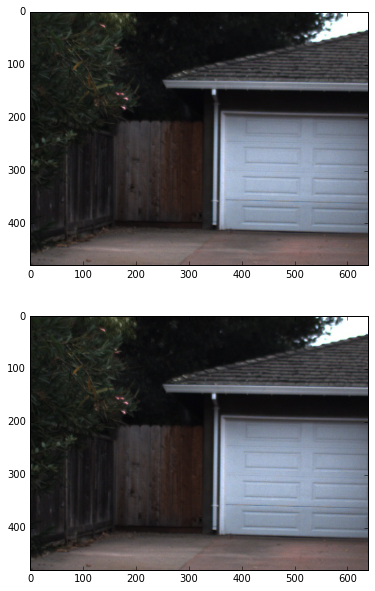

In [5]:
batch_size = 100
x_batch,y_batch,idx = get_random_batch(batch_size)
# validate the shape of batch images and labels are correct
print 'shape of x_batch',np.shape(x_batch)
print 'shape of y_batch',np.shape(y_batch),'\n'
print 'the first pair in the batch has steering angle :',(y_batch[0])
print 'the angle in the original table at current index is also:',input_df['angle'][idx[0]]

print 'the first pair in the batch has photo:'
# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True) 
plt.figure(figsize=(20, 10))
plt.subplot(2,1,1)
plt.imshow(np.asarray(x_batch[0,:,:,:],dtype=np.uint8))
print '\n the corresponding photo is:'
print input_df['filename'][idx[0]]
currentfileName = [input_df['filename'][idx[0]]]
ret = loadImageBatch(currentfileName)
plt.subplot(2,1,2)
plt.imshow(np.asarray(ret[0,:,:,:],dtype=np.uint8))